In [1]:
import plotly.express as px
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torchvision import transforms
from torchsummary import summary
import os
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook


# This solves the crashing issue of matplotlib
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(f'Running on the GPU {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU NVIDIA GeForce RTX 3070


In [3]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.0.0+cu118
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0
**********
CUDNN version: 8700
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3070


In [4]:
# Creating the transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize(0.5, 0.5)
])

In [5]:
# Loading data and applying the transformations
train_images = FashionMNIST(root="./data",
                            train=True,
                            download=True,
                            transform=transform)
test_images = FashionMNIST(root="./data",
                           train=False,
                           download=True,
                           transform=transform)


C:\Users\luisx\pythonvenv\base\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


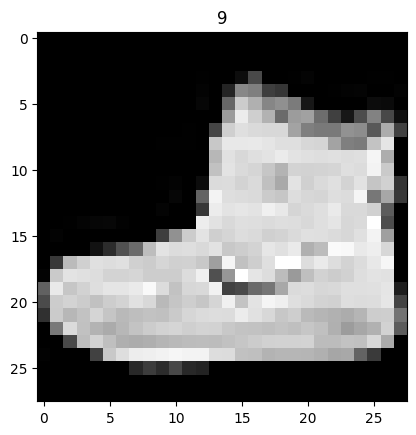

In [6]:
# Plot a single image
image, label = train_images[0]
plt.imshow(image[0], cmap="gray")
plt.title(label)
plt.show()

In [7]:
# Setting dataLoader values
batch_size = 128
workers = 4

# Configuring the dataloaders
train_loader = DataLoader(train_images,
                           batch_size=batch_size,
                           shuffle=False,
                           num_workers=workers,
                           )
test_loader = DataLoader(test_images,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=workers,
                         )


-------------------

# Generator Model

**In this case, as we are creating a generator, we won't feed the image from Fashion MNIST, but noise that the Generator will transform into an image similar to the dataset.**

In [8]:
# Creating the model.
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=64):
        super().__init__()

        # Generator model
        self.dense1 = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=output_dim),
            nn.ReLU(),
        )
        self.dense2 = nn.Sequential( # in=64, output=128
            nn.Linear(output_dim, output_dim*2),
            nn.ReLU(),
        )
        self.dense3 = nn.Sequential( # in=128, output=256
            nn.Linear(output_dim*2, output_dim*4),
            nn.ReLU(),
        )
        self.dense_out = nn.Sequential( # in=256, output=784 (to reshape to (1, 28, 28)
            nn.Linear(output_dim*4, 784), # output_dim*12),
            nn.Tanh(),
        )


    def forward(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense_out(x)
        return x.view((-1, 1, 28, 28))


In [9]:
 # Instance of the generator model
generator = Generator().to(device)
summary(generator, input_size=(1, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           6,464
              ReLU-2                [-1, 1, 64]               0
            Linear-3               [-1, 1, 128]           8,320
              ReLU-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 256]          33,024
              ReLU-6               [-1, 1, 256]               0
            Linear-7               [-1, 1, 784]         201,488
              Tanh-8               [-1, 1, 784]               0
Total params: 249,296
Trainable params: 249,296
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.95
Estimated Total Size (MB): 0.97
----------------------------------------------------------------


**Testing of the generator**

Generated shae: torch.Size([1, 1, 28, 28])


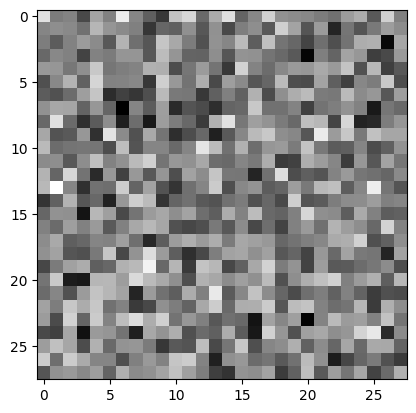

In [10]:
noise = torch.rand([1, 100])
with torch.no_grad():
    generated_image = generator(noise.to(device))

print(f"Generated shae: {generated_image.shape}")
plt.imshow(generated_image.cpu()[0, 0, ...], cmap="gray")
plt.show()

-----------------

# Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=784, output_dim=256):
        super().__init__()

        self.dense1 = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )
        self.dense2 = nn.Sequential(
            nn.Linear(output_dim, output_dim//2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.dense3 = nn.Sequential(
            nn.Linear(output_dim//2, output_dim//4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        self.dense_out = nn.Sequential(
            nn.Linear(output_dim//4, out_features=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = x.view(-1, 784)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense_out(x)

        return x

In [12]:
# Instance of the model
discriminator = Discriminator().to(device)
summary(discriminator, input_size=(1, 28, 28, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
         LeakyReLU-2                  [-1, 256]               0
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
         LeakyReLU-5                  [-1, 128]               0
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
         LeakyReLU-8                   [-1, 64]               0
           Dropout-9                   [-1, 64]               0
           Linear-10                    [-1, 1]              65
          Sigmoid-11                    [-1, 1]               0
Total params: 242,177
Trainable params: 242,177
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

**Testing the discriminator**

In [13]:
noise = torch.rand([1, 28, 28, 1])
with torch.no_grad():
    generated_image = discriminator(noise.to(device))

print(f"Generated shape: {generated_image.shape}")
print(generated_image)

Generated shape: torch.Size([1, 1])
tensor([[0.5109]], device='cuda:0')


------------
**Defining losses**

Explanation:
- *real_loss* -> the discriminator must have to label as **1** all the inputs from the real images, so they will be "True".
    - This will compare the labels that the discriminator calculates (x_real), that must be the closest to 1 as possible. The ones_like(x_real) will create a tensor with the same length (the number of predictions) but all mapped with 1 (as all are "real" we want the discriminator tag them as 1.
    - We will get the loss as how good the model identifies the real images.
- *fake_loss* -> The discriminator must have to label as **0** all the inputs from the generator, as they are fake.
    - This will be done by creating a zeros tensor with the length of the predictions from the generator (x_fake), so we will have the "False" true predictions from those images.
    - The loss will compare how close to 0 were the images from the generator tagged as False or 0.
- *total_loss* -> Is the total loss from the Discriminator. We want that the Discriminator lowers the loss.
    - That is said, that the x_real were closest to 1 and x_fake closest to 0.

For the GeneratorLoss, we want that the predictions from the Discriminator is as close to 1 as possible, that means that the discriminator cannot identify which image is from the dataset and which one is generated.

In [14]:
# Preparing saving folder and training parameters
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "basic_gan_ckpt")

# Training parameters
epochs = 50
noise_dim = 100
num_examples_to_generate = 16


----------------
## Setting the training

  0%|          | 0/50 [00:00<?, ?it/s]

2023-04-09 16:13:03.795 WARNING matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 5, batch: 468 GenLoss:   2.483335, DiscLoss:   0.546756


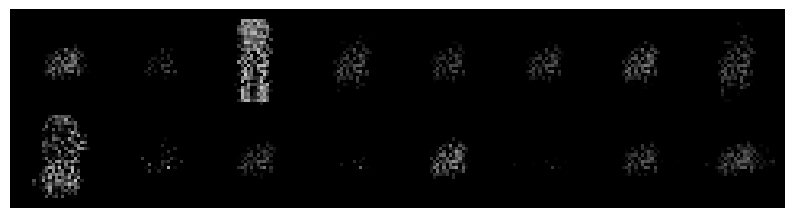

2023-04-09 16:13:47.718 WARNING matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10, batch: 468 GenLoss:   2.648119, DiscLoss:   0.464909


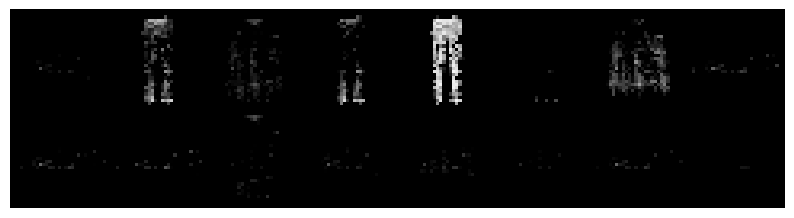

2023-04-09 16:14:31.292 WARNING matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 15, batch: 468 GenLoss:   2.298503, DiscLoss:   0.644379


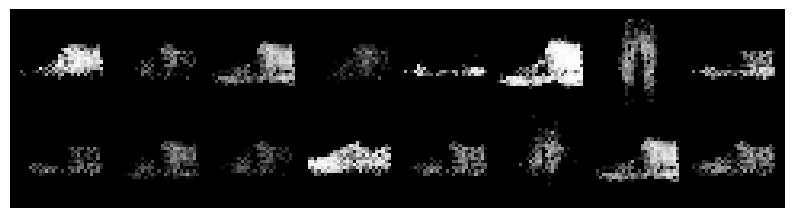

2023-04-09 16:15:14.829 WARNING matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 20, batch: 468 GenLoss:   2.298165, DiscLoss:   0.651800


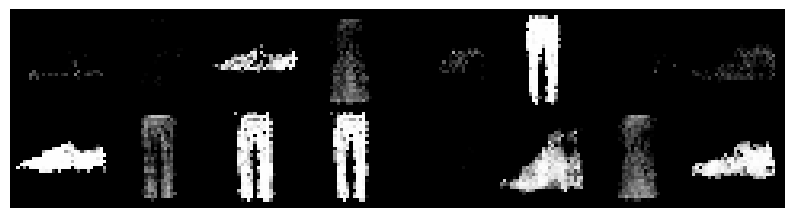

2023-04-09 16:15:58.134 WARNING matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 25, batch: 468 GenLoss:   2.094771, DiscLoss:   0.713169


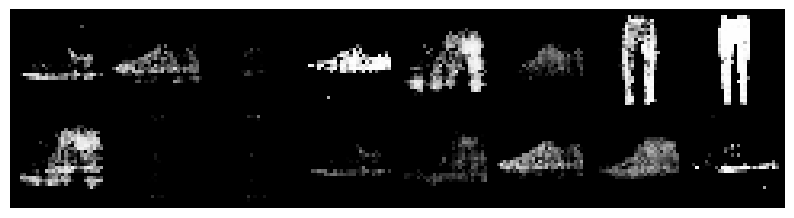

2023-04-09 16:16:42.110 WARNING matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 30, batch: 468 GenLoss:   2.070279, DiscLoss:   0.731738


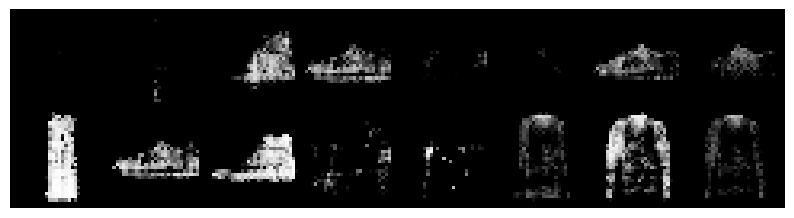

2023-04-09 16:17:25.264 WARNING matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 35, batch: 468 GenLoss:   2.067311, DiscLoss:   0.749500


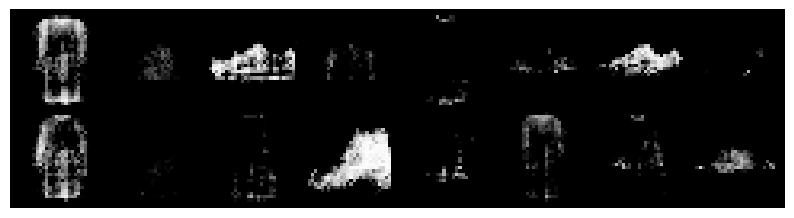

2023-04-09 16:18:08.732 WARNING matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 40, batch: 468 GenLoss:   2.216950, DiscLoss:   0.721320


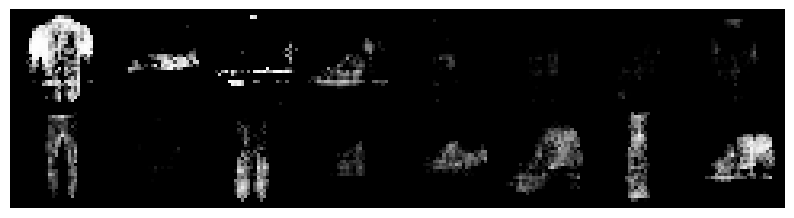

2023-04-09 16:18:51.944 WARNING matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 45, batch: 468 GenLoss:   2.161865, DiscLoss:   0.765949


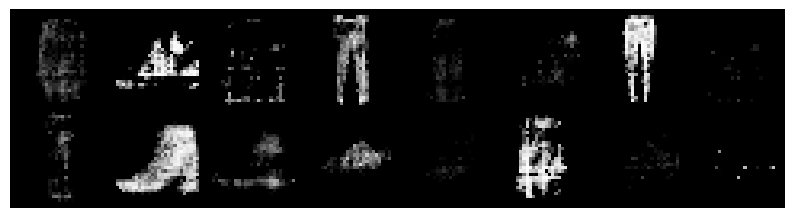

2023-04-09 16:19:35.710 WARNING matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 50, batch: 468 GenLoss:   1.940621, DiscLoss:   0.849883


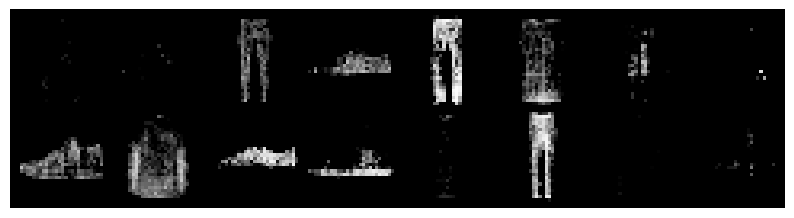

Required time: 435.62205696105957


In [15]:
# Defining our training function
def training(Generator,
             Discriminator,
             train_loader,
             learning_rate=0.001,
             epochs=50,
             noise_dim=100,
             batch_size=128,
             checkpoint_path=False,
             seed=614,
             ):

    def save_model():
        checkpoint_dict = dict(generator_state=generator.state_dict(),
                               discriminator_state=discriminator.state_dict(),
                               generator_optimizer=generator_optimizer.state_dict(),
                               discriminator_optimizer=discriminator_optimizer.state_dict(),
                               )
        torch.save(checkpoint_dir, f"{checkpoint_path}_{epoch}.pth")

    # Finish save_model function==================

    # Init configs ======================
    # Both will use the same optimizer and both will share the criterion.
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Trackers
    gene_losses_list = []
    disc_losses_list = []

    # Setting the seed and time
    torch.manual_seed(seed)
    toc = time.time()

    for epoch in tqdm_notebook(range(epochs)):
        # Training
        gene_total_loss = 0
        disc_total_loss = 0

        for i, (X_train, _) in enumerate(train_loader):
            # Obtaining the data for trqaining
            real_images = X_train.to(device)
            real_labels = torch.ones(real_images.shape[0], 1).to(device) # All 1 with the shape of real_images
            fake_labels = torch.zeros(real_images.shape[0], 1).to(device) # All 0's with shape of real_images

            # Generator training =======
            # Generating the random noise
            noise = torch.randn([real_images.shape[0], noise_dim]).to(device)
            fake_images = Generator(noise)
            # try:
            gen_loss = criterion(discriminator(fake_images), real_labels)
            # except:
            #     print(f"disc_shape: {discriminator(fake_images).shape}, real_shape: {real_labels.shape}, i: {i}")


            generator_optimizer.zero_grad()
            gen_loss.backward()
            generator_optimizer.step()

            # Discriminator training ======
            real_output = Discriminator(real_images)
            fake_output = Discriminator(fake_images.detach())
            real_loss = criterion(real_output, real_labels)
            fake_loss = criterion(fake_output, fake_labels)
            disc_loss = real_loss + fake_loss

            discriminator_optimizer.zero_grad()
            disc_loss.backward()
            discriminator_optimizer.step()

            # Track of the data
            gene_total_loss += gen_loss.item()
            disc_total_loss += disc_loss.item()

        gene_total_loss /= len(train_loader)
        disc_total_loss /= len(train_loader)

        gene_losses_list.append(gene_total_loss)
        disc_losses_list.append(disc_total_loss)


        if (epoch+1) % 5 == 0:
            print(f"Epoch: {epoch+1}, batch: {i} GenLoss: {gene_total_loss:10.6f}, DiscLoss: {disc_total_loss:10.6f}")
            save_model()

            # Testing process
            noise = torch.randn([16, noise_dim])
            generated_images = Generator(noise.to(device))

            with torch.no_grad():
                img = make_grid(generated_images.cpu(), nrow=8)

            plt.figure(figsize=(10, 15))
            plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
            plt.axis("off")
            plt.show()

    epoch = "end"
    save_model()
    print(f"Required time: {time.time() - toc}")

    return gene_losses_list, disc_losses_list


# Training =============================================
gen_loss, disc_loss = training(generator,
                               discriminator,
                               train_loader,
                               0.001,
                               epochs,
                               noise_dim,
                               batch_size,
                               checkpoint_path,
                               )

In [16]:
torch.save(dict(generator=generator,
                discriminator=discriminator), checkpoint_path+"end.pt")

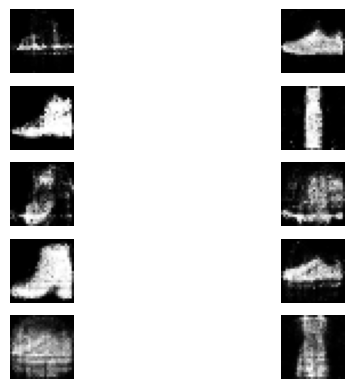

In [19]:
generator.eval()
noise = torch.randn([10, noise_dim])
generated_images = generator(noise.to(device))

with torch.no_grad():
    for i in range(10):
        plt.subplot(5, 2, i+1)
        plt.imshow(generated_images[i, 0, ...].cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()


In [20]:
px.line(gen_loss).show()

In [21]:
px.line(disc_loss).show()